# Assessing the use of Matten for prediction of anisotropic elastic properties

In [1]:
import json
import math

import matplotlib.pyplot as plt
from matten.predict import predict
import numpy as np
import pandas as pd
from pymatgen.core import Structure
from pymatgen.ext.matproj import MPRester
from scipy import optimize
import seaborn as sns
import torch

# This is ELATE (local copy)
import elastic

Let's check that the model is working fine:

In [2]:
a = 5.46
lattice = [[0, a/2, a/2], [a/2, 0, a/2], [a/2, a/2, 0]]
basis = [[0.0, 0.0, 0.0], [0.25, 0.25, 0.25]]
Si = Structure(lattice, ["Si", "Si"], basis)

In [3]:
tensor = predict(Si)

/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a typ

In [4]:
tensor.zeroed().voigt

array([[157.93901062,  58.26101303,  58.26100922,   0.        ,
          0.        ,   0.        ],
       [ 58.26101303, 157.93904114,  58.26103592,   0.        ,
          0.        ,   0.        ],
       [ 58.26100922,  58.26103592, 157.93904114,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  76.43084717,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         76.43083191,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  76.43083191]])

In [5]:
elastic.Elastic(tensor.zeroed().voigt)

In [6]:
elastic.Elastic(tensor.zeroed().voigt).isOrthorhombic()

True

## Load the Matten dataset

The dataset was not in the github repo, but downloaded from Zenodo at https://zenodo.org/doi/10.5281/zenodo.8190849

In [7]:
with open("../datasets/crystal_elasticity_tensor.json", "r") as f:
    data = json.load(f)

In [8]:
data.keys()

dict_keys(['structure', 'formula_pretty', 'crystal_system', 'elastic_tensor', 'elastic_tensor_voigt', 'split'])

In [9]:
set(v for k, v in data['split'].items())

{'test', 'train', 'val'}

In [10]:
test = [k for k, v in data['split'].items() if v == 'test']
len(test)

1021

In [11]:
Structure.from_dict(data['structure']['9023'])

Structure Summary
Lattice
    abc : 5.75486726 5.75486726 5.75539521
 angles : 90.0 90.0 90.0
 volume : 190.61004003343618
      A : 5.75486726 0.0 0.0
      B : 0.0 5.75486726 0.0
      C : 0.0 0.0 5.75539521
    pbc : True True True
PeriodicSite: Cs (2.877, 2.877, 0.03523) [0.5, 0.5, 0.006121]
PeriodicSite: In (0.0, 0.0, 2.96) [0.0, 0.0, 0.5142]
PeriodicSite: Br (0.0, 2.877, 2.956) [0.0, 0.5, 0.5137]
PeriodicSite: Br (0.0, 0.0, 0.08056) [0.0, 0.0, 0.014]
PeriodicSite: Br (2.877, 0.0, 2.956) [0.5, 0.0, 0.5137]

We'll load the structure, the ground truth tensors, and then apply the model to obtain the predicted tensors:

In [12]:
structures = [Structure.from_dict(data['structure'][k]) for k in test]

In [13]:
real_tensor = [np.array(data['elastic_tensor_voigt'][k]) for k in test]

In [14]:
pred_tensor = predict(structures)

/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
Processing...
Done!
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.91s/it]


And now we transform the tensors into `Elastic` object of the ELATE library:

In [15]:
pred_tensor = [elastic.Elastic(x.zeroed().voigt) for x in pred_tensor]

In [16]:
real_tensor = [elastic.Elastic(x) for x in real_tensor]

In [17]:
pred_tensor[0].CVoigt

array([[395.43557739, 124.50571442, 124.50572205,   0.        ,
          0.        ,   0.        ],
       [124.50571442, 395.43560791, 124.50571442,   0.        ,
          0.        ,   0.        ],
       [124.50572205, 124.50571442, 395.43557739,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  90.02210236,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         90.02210999,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  90.02210236]])

In [18]:
pred_tensor[0].isOrthorhombic()

True

## Calculate derived anisotropic (min/max) elastic properties

This takes time, and could be optimized or parallelized, but we only need to do it once.

In [19]:
# Functions from the ELATE base (but not externally exposed)

def minimize(func, dim):
    if dim == 2:
        r = ((0, np.pi), (0, np.pi))
        n = 80
    elif dim == 3:
        r = ((0, np.pi), (0, np.pi), (0, np.pi))
        n = 25
    return optimize.brute(func, r, Ns = n, full_output = True, finish = optimize.fmin)[0:2]

def maximize(func, dim):
    res = minimize(lambda x: -func(x), dim)
    return (res[0], -res[1])

In [20]:
%%time
pred_minE = [minimize(elas.Young, 2) for elas in pred_tensor]
real_minE = [minimize(elas.Young, 2) for elas in real_tensor]

/Users/fx/Desktop/matten/notebooks/elastic.py:680: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/r


CPU times: user 4min 14s, sys: 1.63 s, total: 4min 16s
Wall time: 4min 17s


In [21]:
%%time
pred_maxE = [maximize(elas.Young, 2) for elas in pred_tensor]
real_maxE = [maximize(elas.Young, 2) for elas in real_tensor]

/Users/fx/miniforge3/envs/matten/lib/python3.10/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


CPU times: user 4min 15s, sys: 1.56 s, total: 4min 16s
Wall time: 4min 17s


In [22]:
%%time
pred_minLC = [minimize(elas.LC, 2) for elas in pred_tensor]
real_minLC = [minimize(elas.LC, 2) for elas in real_tensor]

CPU times: user 1min 18s, sys: 359 ms, total: 1min 19s
Wall time: 1min 18s


In [23]:
%%time
pred_maxLC = [maximize(elas.LC, 2) for elas in pred_tensor]
real_maxLC = [maximize(elas.LC, 2) for elas in real_tensor]

CPU times: user 1min 19s, sys: 177 ms, total: 1min 19s
Wall time: 1min 19s


In [24]:
%%time
pred_minG = [minimize(elas.shear, 3) for elas in pred_tensor]
real_minG = [minimize(elas.shear, 3) for elas in real_tensor]

/Users/fx/Desktop/matten/notebooks/elastic.py:705: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(4*r)


CPU times: user 10min 51s, sys: 6.91 s, total: 10min 58s
Wall time: 10min 53s


In [25]:
%%time
pred_maxG = [maximize(elas.shear, 3) for elas in pred_tensor]
real_maxG = [maximize(elas.shear, 3) for elas in real_tensor]

CPU times: user 10min 52s, sys: 6.25 s, total: 10min 58s
Wall time: 10min 53s


In [26]:
%%time
pred_minNu = [minimize(elas.Poisson, 3) for elas in pred_tensor]
real_minNu = [minimize(elas.Poisson, 3) for elas in real_tensor]

/Users/fx/Desktop/matten/notebooks/elastic.py:714: RuntimeWarning: divide by zero encountered in scalar divide
  return -r1/r2


CPU times: user 20min 38s, sys: 6.6 s, total: 20min 45s
Wall time: 20min 47s


In [27]:
%%time
pred_maxNu = [maximize(elas.Poisson, 3) for elas in pred_tensor]
real_maxNu = [maximize(elas.Poisson, 3) for elas in real_tensor]

CPU times: user 20min 50s, sys: 10.9 s, total: 21min 1s
Wall time: 21min 2s


## Saving data to disk

We don't want to have to redo this every time, so we save the data to disk in order to reload it easily.

In [30]:
alldata = {
    "pred_minE": pred_minE,
    "real_minE": real_minE,
    "pred_maxE": pred_maxE,
    "real_maxE": real_maxE,
    "pred_minLC": pred_minLC,
    "real_minLC": real_minLC,
    "pred_maxLC": pred_maxLC,
    "real_maxLC": real_maxLC,
    "pred_minG": pred_minG,
    "real_minG": real_minG,
    "pred_maxG": pred_maxG,
    "real_maxG": real_maxG,
    "pred_minNu": pred_minNu,
    "real_minNu": real_minNu,
    "pred_maxNu": pred_maxNu,
    "real_maxNu": real_maxNu,
}

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open("data_elate.json", "w") as f:
        json.dump(alldata, f, cls=NumpyEncoder)

## First exploration of the anisotropic properties

These are fragments of code from my first exploration of the anisotropic properties above. The proper version of the analysis itself is now down in the second notebook.

/var/folders/h8/9hx_fyj91053ksgdzb2w03vw0000gp/T/ipykernel_18037/21666933.py:4: RuntimeWarning: invalid value encountered in log10
  ax[0].scatter(np.log10(x), np.log10(y), s=2)


(0.0, 50.0)

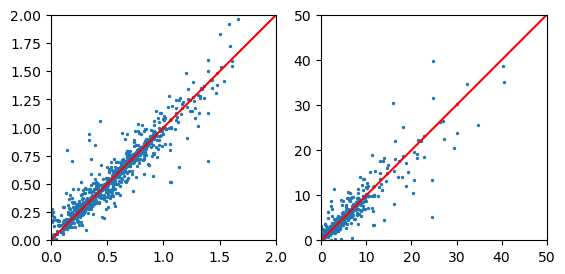

In [31]:
x = np.array([x[1] for x in real_minLC])
y = np.array([x[1] for x in pred_minLC])
fig, ax = plt.subplots(1,2)
ax[0].scatter(np.log10(x), np.log10(y), s=2)
ax[0].set_aspect(1)
ax[0].plot([-10, 10], [-10, 10], c='red')
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2)
ax[1].scatter(x, y, s=2)
ax[1].set_aspect(1)
ax[1].plot([-10, 100], [-10, 100], c='red')
ax[1].set_xlim(0, 50)
ax[1].set_ylim(0, 50)

/var/folders/h8/9hx_fyj91053ksgdzb2w03vw0000gp/T/ipykernel_18037/2054436794.py:4: RuntimeWarning: invalid value encountered in log10
  ax[0].scatter(np.log10(x), np.log10(y), s=2)


(0.0, 50.0)

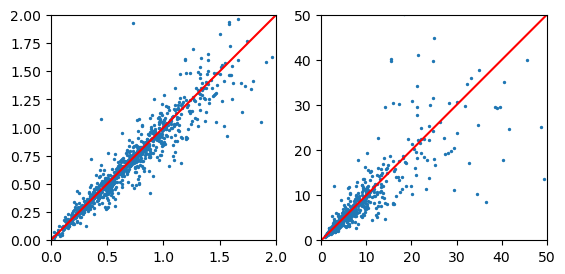

In [32]:
x = np.array([x[1] for x in real_maxLC])
y = np.array([x[1] for x in pred_maxLC])
fig, ax = plt.subplots(1,2)
ax[0].scatter(np.log10(x), np.log10(y), s=2)
ax[0].set_aspect(1)
ax[0].plot([-10, 10], [-10, 10], c='red')
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2)
ax[1].scatter(x, y, s=2)
ax[1].set_aspect(1)
ax[1].plot([-10, 100], [-10, 100], c='red')
ax[1].set_xlim(0, 50)
ax[1].set_ylim(0, 50)

(-1.0, 2.0)

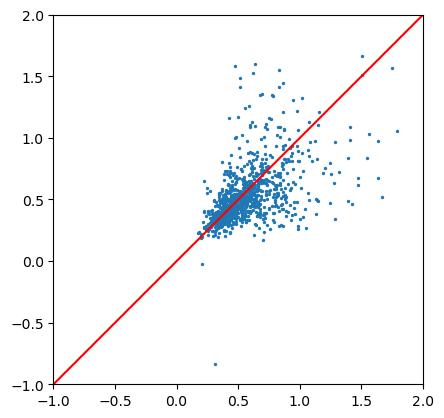

In [33]:
x = np.array([x[1] for x in real_maxNu])
y = np.array([x[1] for x in pred_maxNu])
fig, ax = plt.subplots()
ax.scatter(x, y, s=2)
ax.set_aspect(1)
ax.plot([-10, 100], [-10, 100], c='red')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)

In [34]:
def dirVec(theta, phi):
    return [ math.sin(theta)*math.cos(phi), math.sin(theta)*math.sin(phi), math.cos(theta) ]

correl = [np.dot(dirVec(*real[0]), dirVec(*pred[0])) for real, pred in zip(real_maxE, pred_maxE)]

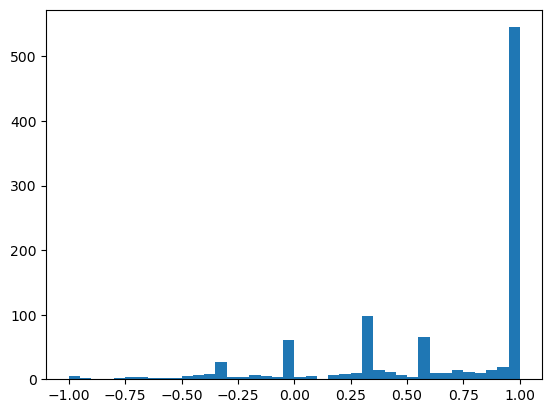

In [35]:
_ = plt.hist(correl, bins=40)

0.2644466209598433

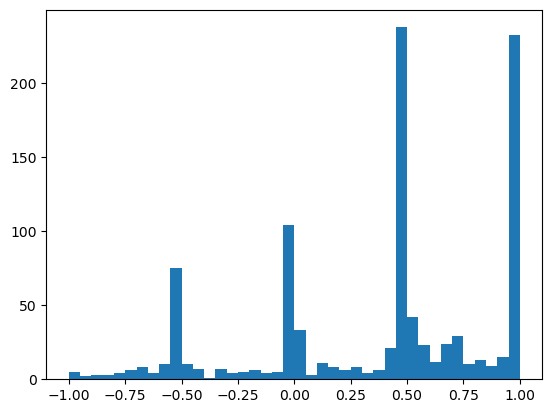

In [36]:
def dirVec1(theta, phi, chi):
    return [ math.sin(theta)*math.cos(phi), math.sin(theta)*math.sin(phi), math.cos(theta) ]
def dirVec2(theta, phi, chi):
    return [ math.cos(theta)*math.cos(phi)*math.cos(chi) - math.sin(phi)*math.sin(chi),
             math.cos(theta)*math.sin(phi)*math.cos(chi) + math.cos(phi)*math.sin(chi),
             - math.sin(theta)*math.cos(chi) ]

correl = [np.dot(dirVec1(*real[0]), dirVec1(*pred[0])) for real, pred in zip(real_maxNu, pred_maxNu)]
plt.hist(correl, bins=40)
np.sum(np.array(correl) > 0.8) / len(correl)

0.2997061704211557

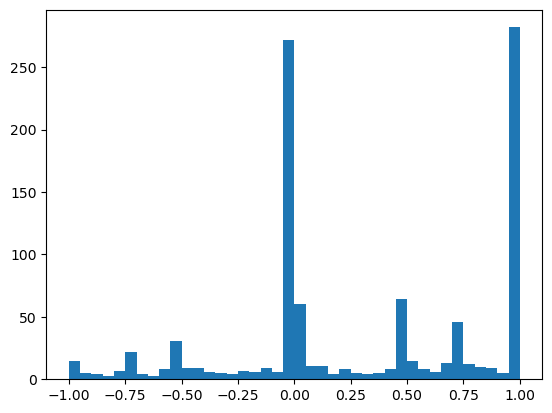

In [37]:
correl = [np.dot(dirVec2(*real[0]), dirVec2(*pred[0])) for real, pred in zip(real_maxNu, pred_maxNu)]
plt.hist(correl, bins=40)
np.sum(np.array(correl) > 0.8) / len(correl)

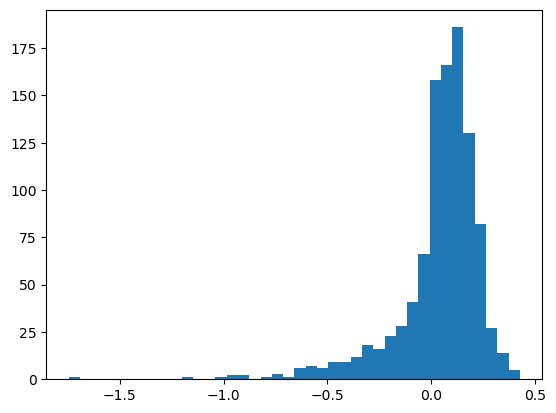

In [38]:
x = np.array([x[1] for x in real_minNu])
y = np.array([x[1] for x in pred_minNu])
_ = plt.hist(x, bins=40)

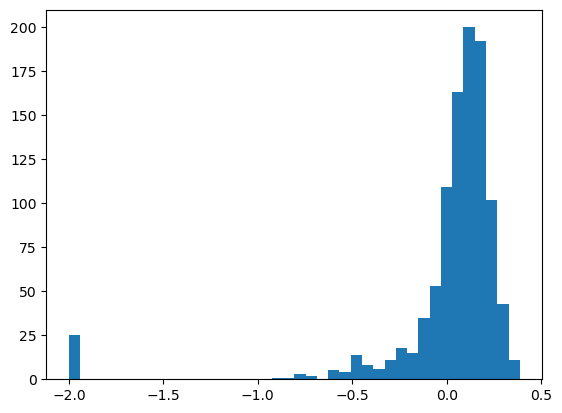

In [39]:
_ = plt.hist(np.fmax(-2, y), bins=40)

In [40]:
x = np.linalg.eigvals(pred_tensor[0].CVoigt)
x.sort()
x

array([ 90.02210236,  90.02210236,  90.02210999, 270.92985535,
       270.92988586, 644.44702148])

In [41]:
x = np.linalg.eigvals(real_tensor[0].CVoigt)
x.sort()
x

array([ 88.44182084,  88.44182084,  88.44182084, 377.37979236,
       377.37979236, 729.25794237])

In [42]:
pred_avg = np.array([elas.averages() for elas in pred_tensor])
real_avg = np.array([elas.averages() for elas in real_tensor])

/var/folders/h8/9hx_fyj91053ksgdzb2w03vw0000gp/T/ipykernel_18037/3785212509.py:4: RuntimeWarning: invalid value encountered in log10
  ax[0].scatter(np.log10(x), np.log10(y), s=2)


(0.0, 400.0)

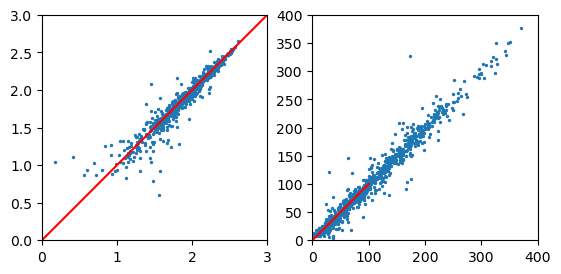

In [43]:
x = np.array([x[2][0] for x in pred_avg])
y = np.array([x[2][0] for x in real_avg])
fig, ax = plt.subplots(1,2)
ax[0].scatter(np.log10(x), np.log10(y), s=2)
ax[0].set_aspect(1)
ax[0].plot([-10, 10], [-10, 10], c='red')
ax[0].set_xlim(0, 3)
ax[0].set_ylim(0, 3)
ax[1].scatter(x, y, s=2)
ax[1].set_aspect(1)
ax[1].plot([-10, 100], [-10, 100], c='red')
ax[1].set_xlim(0, 400)
ax[1].set_ylim(0, 400)